In [1]:
import numpy as np
import pandas as pd

import geopy.distance

import shutil
import os
from collections import OrderedDict

from sklearn import linear_model, metrics

import json

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
from utils.PreProcessor import PreProcessor
preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = False)

**************************************
Loading PreProcessed Datasets
Loaded AirRouteDatasets
Loaded Domestic Passenger Data
Loaded Indian Railways Data
Loaded Socio-Economic Data
Loaded Monument Visitors Data
**************************************


In [3]:
PRESENT_YEAR = 2023

In [4]:
tier_1_2_cities = [
    'Ahmedabad', 'Bengaluru', 'Mumbai', 'Pune', 'Chennai', 'Hyderabad', 'Kolkata', 'Delhi', 'Visakhapatnam', 'Guwahati', 'Patna',
    'Raipur', 'Gurugram', 'Shimla', 'Jamshedpur', 'Thiruvananthapuram', 'Bhopal', 'Bhubaneswar', 'Amritsar', 'Jaipur', 'Lucknow', 'Dehradun'
]
tier_1_2_cities = tier_1_2_cities + (
    "Guntur, Kakinada, Kurnool, Nellore, Rajamahendravaram, Vijayawada".split(', ')
) + (
    "Bilaspur, Bhilai".split(', ')
) + (
    "Anand, Bhavnagar, Dahod, Jamnagar, Rajkot, Surat, Vadodara".split(', ')
) + (
    "Faridabad, Karnal".split(', ')
) + (
    "Hamirpur".split(', ')
) + (
    "Bokaro Steel City, Dhanbad, Ranchi".split(', ')
) + (
    "Belagavi, Hubballi-Dharwad, Kalaburagi, Mangaluru, Mysuru, Vijayapura".split(', ')
) + (
    "Kannur, Kochi, Kollam, Kozhikode, Malappuram, Thrissur".split(', ')
) + (
    "Gwalior, Indore, Jabalpur, Ratlam, Ujjain".split(', ')
) + (
    "Amravati, Aurangabad, Bhiwandi, Dombivli, Jalgaon, Kolhapur, Nagpur, Nanded, Nashik, Sangli, Solapur, Vasai-Virar".split(', ')
) + (
    "Cuttack, Rourkela".split(', ')
) + (
    "Jalandhar, Ludhiana".split(', ')
) + (
    "Ajmer, Bikaner, Jodhpur".split(', ')
) + (
    "Coimbatore, Erode, Madurai, Salem, Thanjavur, Tiruchirappalli, Tirunelveli, Tiruvannamalai, Vellore".split(', ')
) + (
    "Warangal".split(', ')
) + (
    "Agra, Aligarh, Bareilly, Ghaziabad, Gorakhpur, Jhansi, Kanpur, Mathura, Meerut, Moradabad, Noida, Prayagraj, Varanasi".split(', ')
) + (
    "Asansol, Berhampore, Burdwan, Durgapur, Purulia, Siliguri".split(', ')
) + (
    "Chandigarh, Jammu, Puducherry, Srinagar".split(', ')
)

In [5]:
distance_time_curve_fit = np.polyfit(preprocessor.all_network_data['Distance'].values, preprocessor.all_network_data['Time'].values, 1)

def get_route_passenger_traffic_data(cities):
    city_to_city_mapping = dict(zip(preprocessor.city_mapping['DomesticPassengerTraffic_City'], preprocessor.city_mapping['City']))
    route_traffic = []
    for idx, row in preprocessor.total_domestic_data.iterrows():
        if((row['FROM'] in city_to_city_mapping) and (row['TO'] in city_to_city_mapping)):
            route_traffic.append([city_to_city_mapping[row['FROM']], city_to_city_mapping[row['TO']], row['PASSENGERS']])
    route_traffic_df = pd.DataFrame(route_traffic, columns = ['From', 'To', 'Passengers_Target'])
    return route_traffic_df

route_traffic_df = get_route_passenger_traffic_data(tier_1_2_cities)
route_traffic_df['Year'] = pd.Series([PRESENT_YEAR] * route_traffic_df.shape[0])
route_traffic_df['Connecting'] = pd.Series([''] * route_traffic_df.shape[0])

In [6]:
route_traffic_df.shape

(1024, 5)

In [7]:
route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting
0,Agra,Ahmedabad,5164.0,2023,
1,Agra,Bengaluru,28588.0,2023,
2,Agra,Bhopal,2601.0,2023,
3,Agra,Lucknow,5545.0,2023,
4,Agra,Mumbai,15067.0,2023,


In [8]:
def get_railways_info_features(raw_route_traffic_df):
    route_traffic_df = raw_route_traffic_df.copy()
    railway_info = []
    city_to_district_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['StationCodeData_District'].values))
    for idx, row in route_traffic_df.iterrows():
        from_district = city_to_district_mapping[row['From']]
        to_district = city_to_district_mapping[row['To']]
        if(from_district not in preprocessor.city_to_city_train_dict):
            railway_info.append([row['From'], row['To'], row['Year']] + [0, np.nan, np.nan])
        else:
            if(to_district not in preprocessor.city_to_city_train_dict[from_district]):
                railway_info.append([row['From'], row['To'], row['Year']] + [0, np.nan, np.nan])
            else:
                route_railway_info = preprocessor.city_to_city_train_dict[from_district][to_district]
                num_trains = len(route_railway_info)
                avg_duration = np.nanmean([x['duration'] for x in route_railway_info])
                third_ac = np.nansum([x['third_ac'] for x in route_railway_info])
                chair_car = np.nansum([x['chair_car'] for x in route_railway_info])
                first_class = np.nansum([x['first_class'] for x in route_railway_info])
                sleeper = np.nansum([x['sleeper'] for x in route_railway_info])
                second_ac = np.nansum([x['second_ac'] for x in route_railway_info])
                first_ac = np.nansum([x['first_ac'] for x in route_railway_info])
                # Based on https://en.wikipedia.org/wiki/Indian_Railways_coaching_stock & https://www.quora.com/What-is-the-capacity-of-normal-Indian-passenger-train
                #   first_ac -> 20 (1x20)
                #   second_ac -> 100 (2x50)
                #   third_ax -> 180 (3x60)
                #   chair_car -> 150 (75x2)
                #   sleeper -> 840 (12x70)
                #   first_class -> 20 (1x20)
                capacity = (
                    first_ac * 20 +
                    second_ac * 100 +
                    third_ac * 180 +
                    chair_car * 150 +
                    sleeper * 840 +
                    first_class * 20
                )
                # Forecasting growth of railways
                #    -> Based on https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiQp_S3qNP9AhXIwTgGHYuaB5EQFnoECA8QAQ&url=https%3A%2F%2Findianrailways.gov.in%2Frailwayboard%2Fuploads%2Fdirectorate%2Fstat_econ%2FAnnual-Reports-2020-2021%2FAnnual-Report-English.pdf&usg=AOvVaw2YMsSpEfqTOjBD13N-ZsJl,
                #    -> On average, over the past decade, number of passenger coaches increased by ~1000 per year while total running track increased by ~1000 km per year
                #    -> On average, growth rate in railway connectivity & passenger capacity was ~2% per year
                num_trains = num_trains + num_trains * (2 / 100) * (row['Year'] - PRESENT_YEAR)
                capacity = capacity + capacity * (2 / 100) * (row['Year'] - PRESENT_YEAR)
                railway_info.append([row['From'], row['To'], row['Year']] + [num_trains, avg_duration, capacity])
    railway_info_df = pd.DataFrame(railway_info, columns = ['From', 'To', 'Year', 'NumTrains_Railways', 'Duration_Railways', 'Capacity_Railways'])
    route_traffic_df = pd.merge(route_traffic_df, railway_info_df, on = ['From', 'To', 'Year'], how = 'left')
    return route_traffic_df

route_traffic_df = get_railways_info_features(route_traffic_df)

In [9]:
route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways
0,Agra,Ahmedabad,5164.0,2023,,13.0,1114.259615,14560.0
1,Agra,Bengaluru,28588.0,2023,,8.0,1983.722917,4900.0
2,Agra,Bhopal,2601.0,2023,,58.0,456.503154,56470.0
3,Agra,Lucknow,5545.0,2023,,22.0,493.423726,22450.0
4,Agra,Mumbai,15067.0,2023,,12.0,1352.857233,12640.0


In [10]:
OVERLAY_TIME = 120
airport_to_coords_mapping = dict(zip(preprocessor.city_mapping['AirRouteData_AirportCode'].values, preprocessor.city_mapping['Airport_City_Coords'].values))
def get_timing(from_airport, to_airport):
        route_timing_data = preprocessor.all_network_data[(preprocessor.all_network_data['From'] == from_airport) & (preprocessor.all_network_data['To'] == to_airport)]
        if(route_timing_data.shape[0] == 0):
            from_airport_coords = airport_to_coords_mapping[from_airport]
            from_airport_coords_lat = float(from_airport_coords.split(',')[0])
            from_airport_coords_lon = float(from_airport_coords.split(',')[1])
            from_airport_coords = (from_airport_coords_lat, from_airport_coords_lon)
            to_airport_coords = airport_to_coords_mapping[to_airport]
            to_airport_coords_lat = float(to_airport_coords.split(',')[0])
            to_airport_coords_lon = float(to_airport_coords.split(',')[1])
            to_airport_coords = (to_airport_coords_lat, to_airport_coords_lon)
            route_distance = geopy.distance.geodesic(from_airport_coords, to_airport_coords).miles
            route_timing = route_distance * distance_time_curve_fit[0] + distance_time_curve_fit[1]
        else:
            assert(route_timing_data['Time'].nunique() == 1)
            route_distance = route_timing_data['Distance'].mean()
            route_timing = route_timing_data['Time'].mean()
        return route_timing, route_distance

def get_route_timing_features(raw_route_traffic_df):

    route_traffic_df = raw_route_traffic_df.copy()
    route_timings = []
    city_to_airport_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['AirRouteData_AirportCode'].values))
    for idx, row in route_traffic_df.iterrows():
        from_airport = city_to_airport_mapping[row['From']]
        to_airport = city_to_airport_mapping[row['To']]
        connecting = row['Connecting']
        if(connecting == ''):
            route_timing = get_timing(from_airport, to_airport)[0]
        else:
            connecting_airport = city_to_airport_mapping[connecting]
            route_timing = get_timing(from_airport, connecting_airport)[0] + get_timing(connecting_airport, to_airport)[0] + OVERLAY_TIME
        route_timings.append(route_timing)
    route_traffic_df['Duration_AirRoute'] = pd.Series(route_timings)
    route_traffic_df['NumTrains_Railways'] = route_traffic_df['NumTrains_Railways'].fillna(0)
    return route_traffic_df

route_traffic_df = get_route_timing_features(route_traffic_df)

In [11]:
route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways,Duration_AirRoute
0,Agra,Ahmedabad,5164.0,2023,,13.0,1114.259615,14560.0,135.000000
1,Agra,Bengaluru,28588.0,2023,,8.0,1983.722917,4900.0,145.000000
2,Agra,Bhopal,2601.0,2023,,58.0,456.503154,56470.0,77.802403
3,Agra,Lucknow,5545.0,2023,,22.0,493.423726,22450.0,65.000000
4,Agra,Mumbai,15067.0,2023,,12.0,1352.857233,12640.0,119.130475


In [12]:
pca_vals_df = pd.read_csv(f'PreProcessed_Datasets/Models/Present_Features/data_pca_X.csv')
pca_cols = ['City_' + x for x in pca_vals_df.columns if x != 'City']
pca_vals_df.columns = pca_cols + ['City']
pca_vals_df['Year'] = pd.Series([PRESENT_YEAR] * pca_vals_df.shape[0])

total_pca_vals_df = pca_vals_df

In [13]:
total_pca_vals_df.tail()

,City_economic_pca1,City_economic_pca2,City_tourism_pca1,City_tourism_pca2,City_education_pca1,City_education_pca2,City_population_pca1,City_population_pca2,City,Year
57,-8.996071e-02,0.0,-0.225792,-0.065038,0.228733,2.135305,1.629745,-1.593065,Siliguri,2023
58,-1.322687e-16,0.0,0.042147,-0.349667,-4.241148,-1.819083,-2.702539,1.994753,Chandigarh,2023
59,-1.322687e-16,0.0,-0.817877,0.203390,-3.967447,-1.064713,-2.222291,-0.036329,Jammu,2023
60,-1.322687e-16,0.0,-0.817877,0.203390,-4.332237,-1.118788,-2.930138,1.360509,Puducherry,2023
61,-1.322687e-16,0.0,-0.101896,-0.316988,-4.414638,-1.233323,-2.817262,1.112927,Srinagar,2023


In [14]:
def get_pca_vals_features(raw_route_traffic_df):
    route_traffic_df = raw_route_traffic_df.copy()
    route_traffic_df = pd.merge(route_traffic_df, total_pca_vals_df, left_on = ['From', 'Year'], right_on = ['City', 'Year'], how = 'left')
    route_traffic_df = pd.merge(route_traffic_df, total_pca_vals_df, left_on = ['To', 'Year'], right_on = ['City', 'Year'], how = 'left', suffixes = ('_pca_vals_FROM', '_pca_vals_TO'))

    route_traffic_df = route_traffic_df.drop(['City_pca_vals_TO', 'City_pca_vals_FROM'], axis = 1)
    for col in pca_cols:
        route_traffic_df[f'{col}_avg_PCA'] = (route_traffic_df[f'{col}_pca_vals_FROM'] + route_traffic_df[f'{col}_pca_vals_TO']) / 2
        route_traffic_df[f'{col}_diff_PCA'] = (route_traffic_df[f'{col}_pca_vals_FROM'] - route_traffic_df[f'{col}_pca_vals_TO'])
        route_traffic_df = route_traffic_df.drop([f'{col}_pca_vals_FROM', f'{col}_pca_vals_TO', f'{col}_pca_vals_FROM', f'{col}_pca_vals_TO'], axis = 1)

    return route_traffic_df

route_traffic_df = get_pca_vals_features(route_traffic_df)

In [15]:
route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways,Duration_AirRoute,City_economic_pca1_avg_PCA,...,City_tourism_pca2_avg_PCA,City_tourism_pca2_diff_PCA,City_education_pca1_avg_PCA,City_education_pca1_diff_PCA,City_education_pca2_avg_PCA,City_education_pca2_diff_PCA,City_population_pca1_avg_PCA,City_population_pca1_diff_PCA,City_population_pca2_avg_PCA,City_population_pca2_diff_PCA
0,Agra,Ahmedabad,5164.0,2023,,13.0,1114.259615,14560.0,135.000000,-0.172426,...,0.220607,0.034435,2.033819,-6.545985,0.361837,-0.165564,1.423482,-2.774915,0.575270,-1.100329
1,Agra,Bengaluru,28588.0,2023,,8.0,1983.722917,4900.0,145.000000,1.128601,...,-0.042184,0.560017,6.960727,-16.399801,-0.073334,0.704778,3.297287,-6.522525,0.256770,-0.463330
2,Agra,Bhopal,2601.0,2023,,58.0,456.503154,56470.0,77.802403,-0.466923,...,-0.683949,1.843547,-1.829145,1.179943,-0.507111,1.572331,-0.797849,1.667747,0.417191,-0.784170
3,Agra,Lucknow,5545.0,2023,,22.0,493.423726,22450.0,65.000000,-0.257111,...,-0.005929,0.487506,0.147233,-2.772813,-0.567795,1.693699,0.143515,-0.214980,0.401560,-0.752909
4,Agra,Mumbai,15067.0,2023,,12.0,1352.857233,12640.0,119.130475,2.906459,...,-0.851246,2.178141,8.009375,-18.497097,0.209156,0.139797,4.151842,-8.231635,2.661497,-5.272783


In [16]:
route_traffic_df.shape

(1024, 25)

In [17]:
y_features = [x for x in route_traffic_df.columns if x.endswith('_Target')]
X_features = [x for x in route_traffic_df.columns if (x.endswith('_PCA')) or (x.endswith('_AirRoute')) or (x.endswith('_Railways'))]

In [18]:
# Trimming data for model training - Removing routes having no target variable
# Standardizing data
valid_route_traffic_df = route_traffic_df.copy()
cols_standardization_vals = {}
for col_idx, col in enumerate(valid_route_traffic_df.columns):
    if((col in X_features) or (col in y_features)):
        if(col in y_features):
            to_drop_idx = pd.isnull(valid_route_traffic_df[col])
            to_drop_idx = to_drop_idx[to_drop_idx == True].index
            valid_route_traffic_df = valid_route_traffic_df.drop(to_drop_idx, axis = 0)
        elif(col in X_features):
            col_mean = np.nanmean(valid_route_traffic_df[col].values)
            valid_route_traffic_df[col] = valid_route_traffic_df[col].fillna(col_mean)
        col_mean = valid_route_traffic_df[col].mean()
        col_std = valid_route_traffic_df[col].std()
        valid_route_traffic_df[col] = (valid_route_traffic_df[col] - col_mean) / (col_std + 1e-20)
        cols_standardization_vals[col] = {'mean': col_mean, 'std': col_std}

In [19]:
valid_route_traffic_df.head()

,From,To,Passengers_Target,Year,Connecting,NumTrains_Railways,Duration_Railways,Capacity_Railways,Duration_AirRoute,City_economic_pca1_avg_PCA,...,City_tourism_pca2_avg_PCA,City_tourism_pca2_diff_PCA,City_education_pca1_avg_PCA,City_education_pca1_diff_PCA,City_education_pca2_avg_PCA,City_education_pca2_diff_PCA,City_population_pca1_avg_PCA,City_population_pca1_diff_PCA,City_population_pca2_avg_PCA,City_population_pca2_diff_PCA
0,Agra,Ahmedabad,-0.413253,2023,,0.269734,-0.303493,0.282446,0.588996,-0.578523,...,0.199447,0.016679,-0.227020,-0.539063,0.907775,-0.095936,0.328409,-0.653088,-0.190448,-0.343598
1,Agra,Bengaluru,-0.313362,2023,,-0.065388,0.980662,-0.453391,0.854732,0.667925,...,-0.060234,0.271257,0.778719,-1.350527,0.360802,0.408382,1.302934,-1.535105,-0.436807,-0.144684
2,Agra,Bhopal,-0.424183,2023,,3.285833,-1.274967,3.474883,-0.930947,-0.860665,...,-0.694403,0.892963,-1.015573,0.097169,-0.184419,0.911085,-0.826856,0.392512,-0.312722,-0.244872
3,Agra,Lucknow,-0.411628,2023,,0.872954,-1.220437,0.883456,-1.271153,-0.659656,...,-0.024408,0.236135,-0.612132,-0.228342,-0.260693,0.981411,-0.337273,-0.050597,-0.324813,-0.235110
4,Agra,Mumbai,-0.371022,2023,,0.202710,0.048904,0.136193,0.167286,2.371200,...,-0.859719,1.055031,0.992781,-1.523240,0.715868,0.081005,1.747369,-1.937351,1.423248,-1.646525


In [20]:
cols_standardization_vals

{'Passengers_Target': {'mean': 102070.0166015625, 'std': 234495.56452768587},
 'NumTrains_Railways': {'mean': 8.9755859375, 'std': 14.919935873181918},
 'Duration_Railways': {'mean': 1319.7457368484606, 'std': 677.0706238285175},
 'Capacity_Railways': {'mean': 10852.073170731708, 'std': 13127.902428255491},
 'Duration_AirRoute': {'mean': 112.83525112333803, 'std': 37.63139107291316},
 'City_economic_pca1_avg_PCA': {'mean': 0.43142931471778345,
  'std': 1.0437878612329408},
 'City_economic_pca1_diff_PCA': {'mean': 4.163336342344337e-17,
  'std': 2.3378904895173784},
 'City_economic_pca2_avg_PCA': {'mean': 0.0, 'std': 0.0},
 'City_economic_pca2_diff_PCA': {'mean': 0.0, 'std': 0.0},
 'City_tourism_pca1_avg_PCA': {'mean': 0.4606940353519727,
  'std': 1.0782279728271307},
 'City_tourism_pca1_diff_PCA': {'mean': -5.551115123125783e-17,
  'std': 2.435438328491267},
 'City_tourism_pca2_avg_PCA': {'mean': 0.018771543467204804,
  'std': 1.0119780938701717},
 'City_tourism_pca2_diff_PCA': {'mean'

In [21]:
with open(f'./PreProcessed_Datasets/Models/RouteSelection_cols_standardization.json', 'w') as save_file:
    json.dump(cols_standardization_vals, save_file)

In [22]:
data_X = valid_route_traffic_df[X_features].values
data_y = valid_route_traffic_df[y_features].values[:, 0]
data_cities = [(x[0], x[1]) for x in valid_route_traffic_df[['From', 'To']].values]

In [23]:
X_features

['NumTrains_Railways',
 'Duration_Railways',
 'Capacity_Railways',
 'Duration_AirRoute',
 'City_economic_pca1_avg_PCA',
 'City_economic_pca1_diff_PCA',
 'City_economic_pca2_avg_PCA',
 'City_economic_pca2_diff_PCA',
 'City_tourism_pca1_avg_PCA',
 'City_tourism_pca1_diff_PCA',
 'City_tourism_pca2_avg_PCA',
 'City_tourism_pca2_diff_PCA',
 'City_education_pca1_avg_PCA',
 'City_education_pca1_diff_PCA',
 'City_education_pca2_avg_PCA',
 'City_education_pca2_diff_PCA',
 'City_population_pca1_avg_PCA',
 'City_population_pca1_diff_PCA',
 'City_population_pca2_avg_PCA',
 'City_population_pca2_diff_PCA']

In [24]:
data_X.shape, data_y.shape

((1024, 20), (1024,))

/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Coefficients:  [0.05472721870889303, 0.03508471668303333, 0.014484026354109234, 0.05689917313999606, 0.29435002501373986, 0.0023281158792980753, 0, 0, 0.4011009349672868, 0.0018470544834576798, 0.12416005842727568, 0.00017248848632748324, 0.5641558644194823, 0.000591426297305951, 0.25467030342269675, 0.00032537137649537223, 0.1600198625476444, 0.003115602149243036, 0.40626395186957737, 0.00012128745016193197]


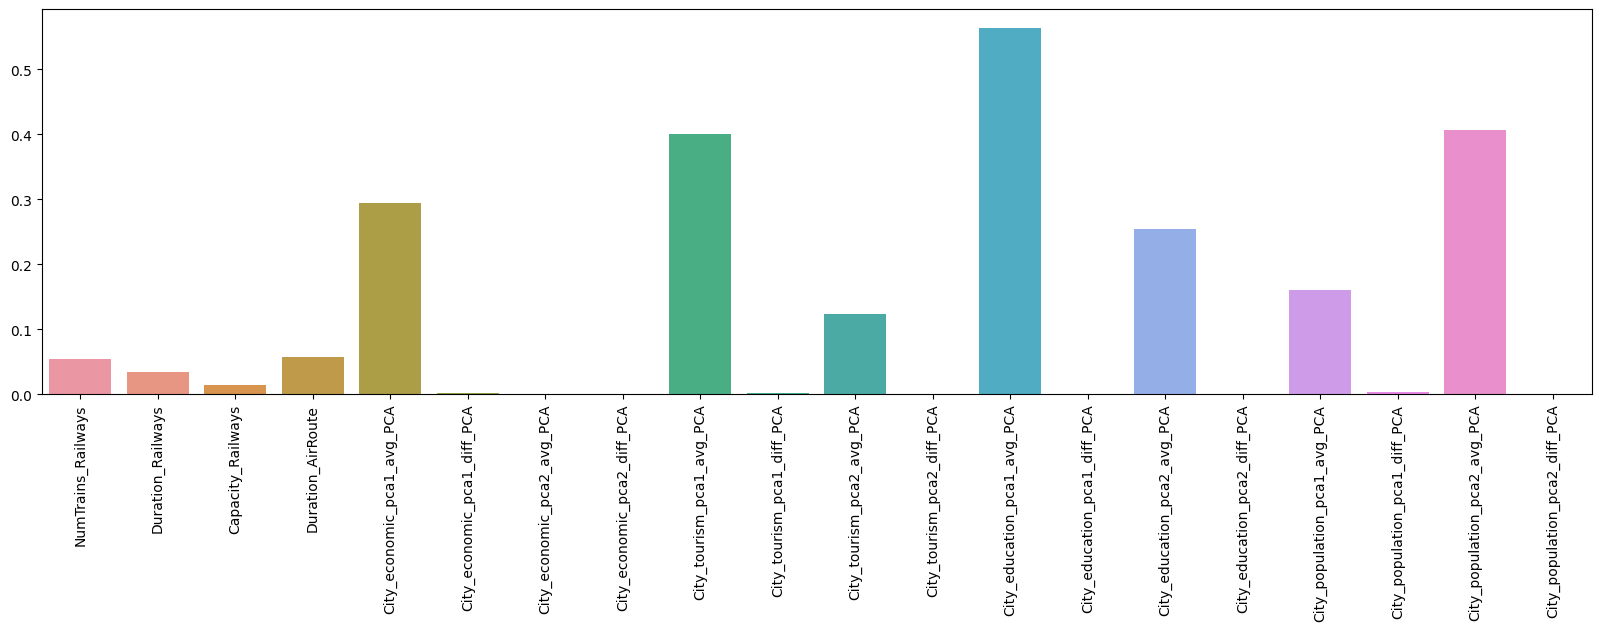

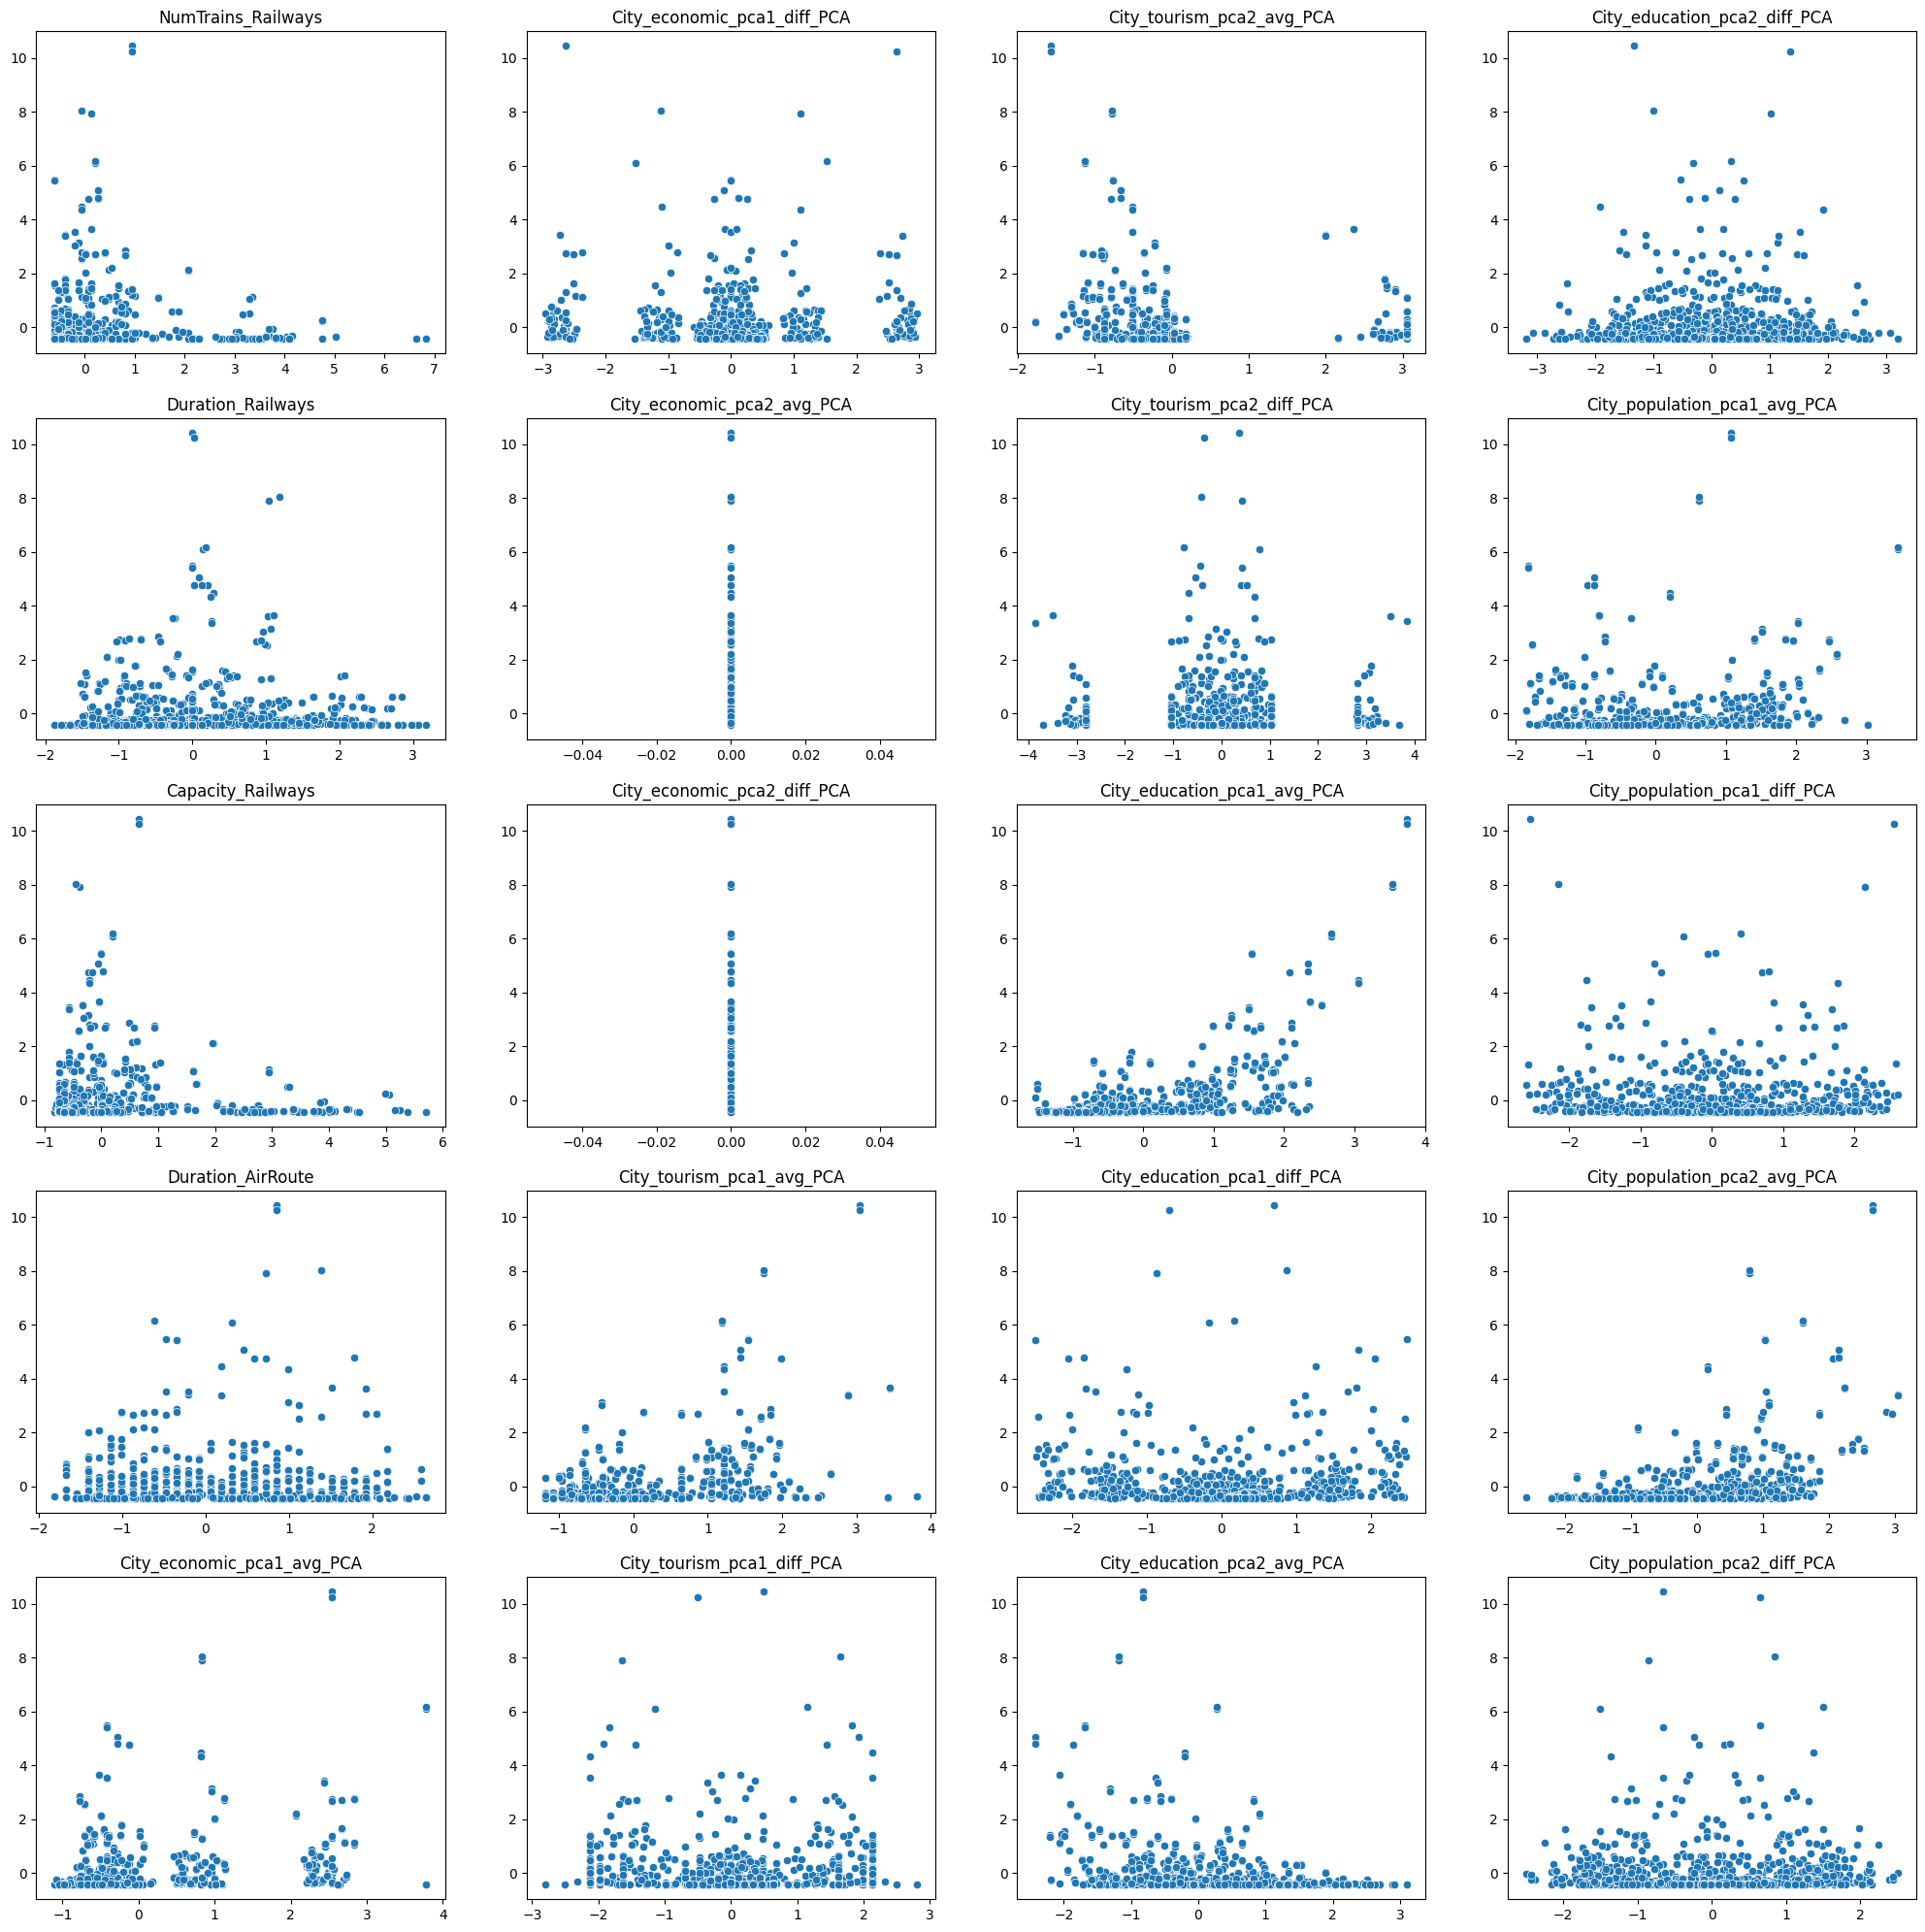

In [25]:
corr_coefs = []
for idx in range(len(X_features)):
    corr = np.abs(np.corrcoef(data_X[:, idx], data_y)[0, 1])
    if(pd.isnull(corr)):
        corr = 0
    corr_coefs.append(corr)
print('Coefficients: ', corr_coefs)
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.barplot(x = X_features, y = corr_coefs, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()
fig, axes = plt.subplots(5, 4, figsize = (25, 25))
for col_idx, col in enumerate(X_features):
    sns.scatterplot(x = data_X[:, col_idx], y = data_y, ax = axes[col_idx % 5, col_idx // 5])
    axes[col_idx % 5, col_idx // 5].set_title(X_features[col_idx])
plt.show()

In [26]:
model = linear_model.LinearRegression()

In [27]:
maes = []
rmses = []
train_test_split_idx = int(0.8 * data_X.shape[0])
all_idx = np.arange(data_X.shape[0])
for train_iter in range(20):
    np.random.shuffle(all_idx)
    train_idx = all_idx[:train_test_split_idx]; test_idx = all_idx[train_test_split_idx:]
    model = linear_model.LinearRegression()
    model.fit(data_X[train_idx], data_y[train_idx])
    target_mean = cols_standardization_vals[y_features[0]]['mean']
    target_std = cols_standardization_vals[y_features[0]]['std']
    true = data_y[test_idx] * target_std + target_mean
    pred = model.predict(data_X[test_idx]) * target_std + target_mean
    pred[pred < 0] = 0
    mae = metrics.mean_absolute_error(true, pred)
    rmse = np.sqrt(metrics.mean_squared_error(true, pred))
#     sns.scatterplot(x = true, y = pred, label = 'Predictions')
#     sns.lineplot(x = true, y = true, label = 'Zero-error Line', color = 'orange')
#     sns.lineplot(x = true, y = true - 2e5, label = 'Lower error bound', color = 'green')
#     sns.lineplot(x = true, y = true + 2e5, label = 'Upper error bound', color = 'green')
#     plt.legend(loc = 'best')
#     plt.title(f"MAE - {mae:.1f}, RMSE - {rmse:.1f}")
#     plt.show()
    maes.append(mae)
    rmses.append(rmse)
np.mean(maes), np.mean(rmses)

(86806.47434578625, 167097.18034609483)

In [28]:
model = linear_model.LinearRegression()
model.fit(data_X, data_y)
model_coefs = OrderedDict(zip(['intercept'] + [*X_features], [model.intercept_] + [*model.coef_]))

In [29]:
import json
with open(f'./PreProcessed_Datasets/Models/RouteSelectionModel_coefs.json', 'w') as save_file:
    json.dump(model_coefs, save_file)